In [1]:
# Import Libraries
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from config_user_dta import config
from bs4 import BeautifulSoup
import requests
import boto3
import geopandas as gpd
import geocoder
import geopy
import datetime
from config import aws_access_key, aws_secret_access

In [2]:
#Read the files from AWS bucket
listings_df=pd.read_csv("s3://bc-final-airbnb-data/listings.csv.gz", storage_options={"anon":True})
calendar_df=pd.read_csv("s3://bc-final-airbnb-data/calendar.csv.gz", storage_options={"anon":True})

In [3]:
# Read listings dataframe
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20220605131750,2022-06-06,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.08
1,8077,https://www.airbnb.com/rooms/8077,20220605131750,2022-06-05,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,...,4.90,4.92,4.83,NaN,t,2,1,1,0,1.08
2,27423,https://www.airbnb.com/rooms/27423,20220605131750,2022-06-05,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,https://www.airbnb.com/users/show/118124,...,5.00,4.82,4.82,NaN,f,1,1,0,0,0.18
3,30931,https://www.airbnb.com/rooms/30931,20220605131750,2022-06-05,Downtown Toronto - Waterview Condo,Split level waterfront condo with a breathtaki...,NaN,https://a0.muscache.com/pictures/227971/e8ebd7...,22795,https://www.airbnb.com/users/show/22795,...,NaN,NaN,NaN,NaN,f,2,1,1,0,0.01
4,40456,https://www.airbnb.com/rooms/40456,20220605131750,2022-06-05,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,This is Nice Neighborhood located in Downtown ...,https://a0.muscache.com/pictures/b36b6ae3-20aa...,174063,https://www.airbnb.com/users/show/174063,...,4.96,4.57,4.68,NaN,f,4,4,0,0,0.79


In [4]:
# Read calendar dataframe
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1419,2022-06-06,f,$469.00,$469.00,28.0,730.0
1,1419,2022-06-07,f,$469.00,$469.00,28.0,730.0
2,1419,2022-06-08,f,$469.00,$469.00,28.0,730.0
3,1419,2022-06-09,f,$469.00,$469.00,28.0,730.0
4,1419,2022-06-10,f,$469.00,$469.00,28.0,730.0


# Data Cleaning and Transformation

## Listings

In [5]:
#Check the columns in the dataset
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

#### The aim of this project is to predict AirBnB prices. Since we are not using Natural Language Processing, we will drop the columns that are not required for the purpose of this project.

In [6]:
cols_to_drop=['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview','picture_url','host_id',
              'host_url','host_name', 'host_location','host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
              'host_verifications', 'bathrooms_text', 'host_acceptance_rate', 'neighbourhood_group_cleansed','minimum_minimum_nights',
              'maximum_minimum_nights', 'minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
              'calendar_last_scraped', 'license','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','host_has_profile_pic',
              'maximum_nights_avg_ntm', 'has_availability', 'number_of_reviews_l30d','host_total_listings_count','neighbourhood','calendar_updated','reviews_per_month']
             
    
listings_df=listings_df.drop(cols_to_drop, axis=1)
listings_df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,1419,2008-08-08,NaN,NaN,f,1.0,t,Little Portugal,43.64590,-79.42423,...,2015-07-19,2017-12-04,5.00,5.00,5.00,5.00,5.00,5.00,5.00,f
1,8077,2009-06-22,NaN,NaN,f,2.0,f,Waterfront Communities-The Island,43.64080,-79.37673,...,2009-08-20,2013-08-27,4.84,4.81,4.89,4.87,4.90,4.92,4.83,t
2,27423,2010-05-04,within a few hours,100%,f,1.0,t,South Riverdale,43.66884,-79.32725,...,2010-06-07,2011-08-30,4.92,5.00,4.82,5.00,5.00,4.82,4.82,f
3,30931,2009-06-22,NaN,NaN,f,2.0,f,Waterfront Communities-The Island,43.64015,-79.37625,...,2010-08-11,2010-08-11,5.00,NaN,NaN,NaN,NaN,NaN,NaN,f
4,40456,2010-07-20,within an hour,100%,t,3.0,t,South Parkdale,43.63539,-79.44010,...,2010-08-03,2022-01-29,4.63,4.64,4.66,4.95,4.96,4.57,4.68,f


In [7]:
# Check for null values
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15171 non-null  int64  
 1   host_since                   15168 non-null  object 
 2   host_response_time           10451 non-null  object 
 3   host_response_rate           10451 non-null  object 
 4   host_is_superhost            15168 non-null  object 
 5   host_listings_count          15168 non-null  float64
 6   host_identity_verified       15168 non-null  object 
 7   neighbourhood_cleansed       15171 non-null  object 
 8   latitude                     15171 non-null  float64
 9   longitude                    15171 non-null  float64
 10  property_type                15171 non-null  object 
 11  room_type                    15171 non-null  object 
 12  accommodates                 15171 non-null  int64  
 13  bathrooms       

#### Cleaning and Transforming Individual Columns

In [8]:
# host_since
#Convert object to datetime
listings_df["host_since"]=pd.to_datetime(listings_df["host_since"])

#Calculate the number of days
listings_df["host_active_days"]=(pd.datetime(2022,6, 6)-listings_df["host_since"]).astype('timedelta64[D]')

#Calculate the mean and median
print(round(listings_df["host_active_days"].mean(),2))
print(listings_df["host_active_days"].median())

# Fill the null values with median values
listings_df["host_active_days"].fillna(listings_df["host_active_days"].median(), inplace=True)

#Drop the original column
listings_df.drop(["host_since"], axis=1, inplace=True)

2083.97
2134.0


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [9]:
# host_response_time
print("Null Values:", listings_df["host_response_time"].isnull().sum())
print("Proportion:", round(listings_df["host_response_time"].isna().sum()/len(listings_df)*100,1))

#Replace null values with "unknown"
listings_df["host_response_time"].fillna("unknown", inplace=True)
listings_df["host_response_time"].value_counts()

Null Values: 4720
Proportion: 31.1


within an hour        6393
unknown               4720
within a few hours    2051
within a day          1431
a few days or more     576
Name: host_response_time, dtype: int64

In [10]:
# host_response_rate
# Convert column datatype to float
listings_df["host_response_rate"]=listings_df["host_response_rate"].str[:-1].astype('float64')

#Bin the values into four categories
bins=[0, 50, 90,99, 100]
group_names=["0-49%", "50-89%", "90-99%", "100%"]
listings_df["host_response_rate"]= pd.cut(listings_df["host_response_rate"], bins=bins, labels=group_names, include_lowest=True)

In [11]:
# Convert column to string
listings_df["host_response_rate"]= listings_df["host_response_rate"].astype('str')

#Replace null values with "unknown"
listings_df["host_response_rate"].replace("nan", "unknown", inplace=True)

#Check the value counts
listings_df["host_response_rate"].value_counts()

100%       6995
unknown    4720
50-89%     1471
90-99%     1299
0-49%       686
Name: host_response_rate, dtype: int64

In [12]:
# property_types

#Replacing and grouping multiple categories into main heads

listings_df["property_type"].replace({
    "Entire home": "House",
    "Private room in rental unit": "One Room",
    "Entire rental unit": "Apartment",
    "Entire condo" : "Apartment",
    "Private room in home": "One Room",
    "Private room in condo": "One Room",
    "Shared room in parking space": "Shared Room",
    "Entire guest suite": "Apartment",
    "Entire townhouse": "House",
    "Private room in bed and breakfast": "One Room",
    "Private room in townhouse": "One Room",
    "Private room in tiny home": "One Room",
    "Private room in guest suite": "One Room",
    "Private room in loft": "One Room",
    "Private room in cottage" : "One Room",
    "Private room in bungalow": "One Room",
    "Private room in guesthouse": "One Room",
    "Private room": "One Room",
    "Private room in vacation home": "One Room",
    "Private room in floor": "One Room",
    "Private room in villa": "One Room",
    "Room in hostel": "One Room",
    "Private room in castle": "One Room",
    "Room in hotel": "One Room",
    "Private room in barn": "One Room",
    "Room in boutique hotel": "One Room",
    "Room in bed and breakfast": "One Room",
    "Private room in serviced apartment": "One Room",
    "Private room in casa particular": "One Room",
    "Private room in earthen home" : "One Room",
    "Room in aparthotel": "One Room",
    "Private room in hut": "One Room",
    "Private room in hostel": "One Room",
    "Private room in holiday park": "One Room",
    "Shared room in rental unit" : "Shared Room",
    "Shared room in home": "Shared Room",
    "Shared room in condo": "Shared Room",
    "Shared room in townhouse": "Shared Room",
    "Shared room in bed and breakfast": "Shared Room",
    "Shared room in bungalow": "Shared Room",
    "Shared room in hostel": "Shared Room",
    "Shared room in loft": "Shared Room",
    "Shared room in guesthouse": "Shared Room",
    "Shared room in villa": "Shared Room",
    "Shared room in barn": "Shared Room",
    "Shared room in boat": "Shared Room",
    "Shared room in hotel": "Shared Room",
    "Shared room in guest suite": "Shared Room",
    "Entire bungalow": "House",
    "Tiny home": "House",
    "Entire villa": "House",
    "Entire place": "House",
    "Entire cottage": "House",
    "Earthen home": "House",
    "Entire vacation home": "House",
    "Entire serviced apartment": "Apartment",
    "Entire loft": "Apartment",
    "Entire guesthouse": "House",
    "Entire home/apt": "House"},inplace=True)

#Replacing other categories with 'other'
listings_df.loc[~listings_df["property_type"].isin(["House", "Apartment", "One Room", "Shared Room"]), "property_type"]="Other"
    
# Check the property type value count
listings_df["property_type"].value_counts()

Apartment      7885
One Room       4700
House          2443
Shared Room     131
Other            12
Name: property_type, dtype: int64

In [13]:
# bathrooms, bedrooms and beds

# Drop the bathroom column since no data is available
listings_df=listings_df.drop("bathrooms", axis=1)

# Replace missing values with median for bedrooms and beds
for col in ["bedrooms", "beds"]:
    listings_df[col].fillna(listings_df[col].median(), inplace=True)

In [14]:
# Amenities
listings_df["amenities"]

0        ["Smoke alarm", "Dryer", "Washer", "Air condit...
1        ["Pool", "Smoke alarm", "Free parking on premi...
2        ["Central heating", "Barbecue utensils", "Drye...
3        ["Pool", "Smoke alarm", "Free parking on premi...
4        ["Washer", "Heating", "Dishwasher", "Wifi", "K...
                               ...                        
15166    ["Smoke alarm", "Dryer", "Washer", "Refrigerat...
15167    ["Dryer", "Washer", "Toaster", "Patio or balco...
15168    ["Central heating", "Dryer", "Washer", "Securi...
15169    ["Washer", "Cleaning before checkout", "Heatin...
15170    ["Lockbox", "Patio or balcony", "Heating", "Wi...
Name: amenities, Length: 15171, dtype: object

In [15]:
#Creating a set of amenities
amenities_list = list(listings_df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)

In [16]:
#Grouping the amenities into separate columns with 1 if amenities present and 0 if not present
listings_df.loc[listings_df['amenities'].str.contains('shampoo|body soap|One Man Jack body soap|Kirkland Bodywash body soap|Different types shampoo|Several hotel brands body soap|V05 shampoo|Head & shoulders  conditioner|Several Hotel Brands Available body soap|Shampoo|dove  body soap|Pantene or Herbal Essences shampoo|Alaffia EveryDay Shea Conditioner Lavender conditioner|Herbal Essence Body Wash body soap|Pert shampoo|Le Labo conditioner|Natural bar soaps will be provided  body soap|L\'oreal shampoo|Loreal body soap|Basic  body soap|Premium  body soap|Pantene  shampoo|L\'Or\\u00e9al conditioner|Salon brands shampoo|Truly Earth body soap|Coconut conditioner|L\\u2019Or\\u00e9al  body soap|TRESEMME conditioner|Body wash body soap|Yves Rocher shampoo|Adidas conditioner|Aveena conditioner|L\'Oreal  body soap|Olay body soap|Canadian shampoo|Pantene Pro V conditioner|Generic body soap|Myriade d\\u2019arabe shampoo|Basic shampoo|Sukin body soap|TRESemm\\u00e9 shampoo|Name brand  body soap|Dove conditioner conditioner|Ivory bar soap body soap|Tresemme conditioner|Boo Bamboo Conditioner conditioner|Coconut shampoo|Body lotion and soap body soap|Dove bar soap  body soap|Eco Botanics  conditioner|Best available neutral body wash body soap|Head & Shoulders shampoo|Softsoap  body soap|Head&shoulder shampoo|Irish Fresh body soap|Alaffia body soap|Dr Bronners  body soap|Pears body soap|Various brands  shampoo|Regular  shampoo|Everyone shampoo|Numerous  body soap|Dove - Natural  body soap|Plushresidence brand body soap|North American Hemp Co. - natural product body soap|Argan Oil conditioner|we will arrange for it body soap|Hypoallergenic body soap|Soft body soap|Head and Shoulder shampoo|Essenes  body soap|Pantene 2-in-1 conditioner|Ivory Bar Soap body soap|Kirkland/ivory or similar body soap|Head & Shoulders conditioner|Pantene Daily Moisture Renewal shampoo|Ivory clean body soap|LUSH body soap|H&S shampoo|Natural conditioner|Head And Shoulder|Different  shampoo|Lavender soap from bulk barn body soap|Truly Earth shampoo|Pantene or similar conditioner|Nivea & Dove body soap|Toiletries|Head&Shoulder shampoo|Eco Botanics  body soap|Dr. Bronner\\u2019s body soap|Body Wash body soap|Noname conditioner|KIRKLAND shampoo|organic hypo-allergenic body soap|Organic conditioner|Liveclean shampoo|Iris Spring body soap|Dove  shampoo|Various conditioner|Variety brands body soap|Various brands  conditioner|TRESemm\\u00e9 conditioner|Alaffia - natural product conditioner|Johnsons & Johnson conditioner|Hotel Brands Available shampoo|General body soap|Moroccan oil conditioner|Natural shampoo|No name body soap|Luxury shampoo|Old Spice ?  body soap|Several hotel brands  conditioner|American  body soap|Assorted Quality Brands  shampoo|H\\u00f4tel-time shampoo|No name  body soap|Prosilk  shampoo|Known brands shampoo|IVORY clean body soap|Iris spring  body soap|Herbal Essence shampoo|Tre semme conditioner|SOS and lemon dish soap conditioner|Marc Antony conditioner|ProSilk body soap|Garnier Fructis shampoo|Aveeno body soap'),"toiletries"]=1
listings_df.loc[listings_df['amenities'].str.contains('Game console|Philip sound system with Bluetooth and aux|Record player|TV|TV with standard cable|Cable TV|39\\ TV|Beats Speaker sound system with Bluetooth and aux|JBL Bluetooth sound system|40\\ HDTV with Netflix|55\\ TV with Amazon Prime Video|90\\ TV with Apple TV|44\\ HDTV with Roku|43\\ TV|32\\ TV with Chromecast|Game console: Nintendo Wii and Xbox One|Alexa sound system with Bluetooth and aux|43\\ TV|36\\ HDTV|57\\ HDTV with Netflix|46\\ HDTV with Roku|68\\ HDTV with Netflix|46\\ HDTV with standard cable|46\\ TV with Chromecast|Radio and CD player sound system|Savant sound system|Radio and CD player sound system|24\\ TV with Chromecast|Sony  sound system with aux|Sonos\\u2122 Bluetooth sound system|55\\ TV with Chromecast|Google Smart Speaker Bluetooth sound system|Roku Bluetooth sound system|HDTV with standard cable|52\\ HDTV|Bluetooth speaker Bluetooth sound system|Denon sound system|54\\ HDTV with Apple TV|Chromecast|37\\ HDTV with Amazon Prime Video|Samsung Sound Bar sound system with Bluetooth and aux|26\\ HDTV with standard cable|Denon - connect via wifi sound system|42\\ HDTV with Netflix|78\\ HDTV with Netflix|37\\ TV with Netflix|75\\ HDTV|Alexa sound system|Samsung Bluetooth Speaker  Bluetooth sound system|43\\ HDTV with Amazon Prime Video|60\\ TV with standard cable|47\\ TV with Roku|Sonos 5 & 1 Bluetooth sound system|49\\ HDTV with Netflix|Netflix|43\\ HDTV with Amazon Prime Video|43\\ HDTV with standard cable|50\\ HDTV with HBO Max|Bose Boom Box Bluetooth sound system|30\\ HDTV with Netflix|46\\ HDTV|48\\ HDTV with Chromecast|Sonos or Old School Turntable sound system with Bluetooth and aux|52\\ HDTV with premium cable|48\\ HDTV with Roku|50\\ HDTV with Netflix|Game console: PS4|60\\ HDTV with standard cable|Wonderboom Bluetooth sound system|Bose sound touch Bluetooth sound system|Wireless speakers available - compatible with all electronic devices sound system|55\\ TV with Netflix|48\\ TV with standard cable|TV with Apple TV|43\\ TV with Roku|54\\ HDTV with Apple TV|Alexa - Amazon  sound system|42\\ HDTV with Roku|65\\ HDTV with Amazon Prime Video|52\\ TV|32\\ HDTV|SONOS Bluetooth sound system|40\\ HDTV with Roku|58\\ HDTV with Apple TV|Samsung Soundbar Bluetooth sound system|37\\ HDTV with|50\\ HDTV with Roku|82\\ HDTV with Netflix|85\\ HDTV|85\\ HDTV with Amazon Prime Video|37\\ HDTV with Netflix|42\\ TV with Amazon Prime Video|32\\ TV with premium cable|Marshall Bluetooth sound system|45\\ HDTV with|46\\ HDTV with Netflix|42\\ HDTV with Netflix|TV with HBO Max|65\\ TV with Amazon Prime Video|Bose Bluetooth  Bluetooth sound system|Eneby Bluetooth sound system|LG Soundbar and Sub sound system|55\\ HDTV with Amazon Prime Video|47\\ TV with Netflix|48\\ TV|32\\ TV with Apple TV|58\\ HDTV|Polaroid sound system with Bluetooth and aux|40\\ HDTV with premium cable|70\\ HDTV with Apple TV|42\\ HDTV|48\\ HDTV with Apple TV|18\\ TV with Netflix|43\\ TV with Chromecast|Sound system|55\\ TV with standard cable|46\\ HDTV with Amazon Prime Video|38\\ TV|Google Home sound system|45\\ HDTV with Roku|30\\ HDTV|54\\ HDTV with Netflix|65\\ HDTV|55\\ HDTV with premium cable|40\\ HDTV with Chromecast|36\\ HDTV|37\\ TV with Netflix|65\\ TV with Apple TV|65\\ HDTV with premium cable|78\\ HDTV with Netflix|70\\ HDTV with Netflix|Sony 7.2 Surround Sound sound system with Bluetooth and aux|50\\ TV with Amazon Prime Video|Bose Mini Bluetooth sound system|45\\ HDTV|90\\ TV with Apple TV|Chromecast|65\\ HDTV with Apple TV|49\\ TV with Apple TV|Sony sound system|70\\ HDTV with Chromecast|52\\ TV with|33\\ HDTV with Chromecast|30\\ HDTV with Amazon Prime Video|46\\ HDTV with Amazon Prime Video|45\\ TV with Amazon Prime Video'), 'high_end_electronics'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Air conditioning|Window AC unit|Central air conditioning|Heating|Indoor Fireplace|Central Heating|Central air conditioning|Central heating'), 'ac_heater'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Internet|Pocket wifi|Wifi|wifi'), 'internet'] = 1
listings_df.loc[listings_df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque|Barbecue utensils'), 'bbq'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Freezer|Hot water kettle|Microwave|Fridge|Toaster Oven|Samsung  stainless steel stove|Paid dryer|GE stainless steel oven|Samsung refrigerator|LG - Stainless Steel refrigerator|G.E.  stainless steel gas stove|Induction stove|GE Self Clean stainless steel oven|Brevettie  oven|Hair dryer|Hot plates  electric stove|Black & Decker stainless steel oven|Smsub oven|FRIGIDAIRE refrigerator|Dryer|Hangers|stove|Dishwasher|mini-fridge|electric stove|Washer'), "home_appliances"]=1
listings_df.loc[listings_df['amenities'].str.contains('Coffee maker|Nespresso|Pour-over coffee|Cafe'),'coffee_machine']=1
listings_df.loc[listings_df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Fire extinguisher|Smoke alarm|First aid kit'),'safety']=1
listings_df.loc[listings_df['amenities'].str.contains('Balcony|Patio|Private fenced garden or backyard|Garden|Outdoor|Sun loungers|Terrace|Backyard'), 'outdoor_space'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Ceiling fan|Bathtub|Clothing storage|closet|walk-in closet|Room-darkening shades|Crib|Bedroom comforts|Dedicated workspace|Extra pillows and blankets|Bed Linens|linens'),"room_features"]=1
listings_df.loc[listings_df['amenities'].str.contains('Family/kid friendly|Children|children|Baby bath'), 'child_friendly'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Laundry services|Hot water|Laundromat|Free carport on premises|EV charger'),"other_facilities"]=1
listings_df.loc[listings_df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront|Kayak'), 'nature_and_views'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Free parking on premises|Paid parking on premises|parking|valet parking'), 'parking'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Cooking basics|Kitchen'), 'kitchen'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listings_df.loc[listings_df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [17]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15171 non-null  int64  
 1   host_response_time           15171 non-null  object 
 2   host_response_rate           15171 non-null  object 
 3   host_is_superhost            15168 non-null  object 
 4   host_listings_count          15168 non-null  float64
 5   host_identity_verified       15168 non-null  object 
 6   neighbourhood_cleansed       15171 non-null  object 
 7   latitude                     15171 non-null  float64
 8   longitude                    15171 non-null  float64
 9   property_type                15171 non-null  object 
 10  room_type                    15171 non-null  object 
 11  accommodates                 15171 non-null  int64  
 12  bedrooms                     15171 non-null  float64
 13  beds            

In [18]:
# Replacing nulls with zeros for new columns
replace_nulls = listings_df.iloc[:,36:].columns
listings_df[replace_nulls] = listings_df[replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in listings_df.iloc[:,36:].columns:
    if listings_df[col].sum() < len(listings_df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
listings_df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
listings_df.drop('amenities', axis=1, inplace=True)

['breakfast', 'child_friendly', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [19]:
# List of Amenities that will be included
listings_df.columns[36:]

Index(['ac_heater', 'internet', 'bbq', 'home_appliances', 'coffee_machine',
       'long_term_stays', 'host_greeting', 'safety', 'outdoor_space',
       'hot_tub_sauna_or_pool', 'room_features', 'other_facilities',
       'private_entrance', 'parking', 'kitchen', 'elevator', 'gym'],
      dtype='object')

In [20]:
# price

# Convert the price column to float
listings_df["price"]=listings_df["price"].str.replace(",","",regex=True).str.replace("$", "",regex=True)
listings_df["price"]=listings_df["price"].astype(float)

In [21]:
# availability
# We will retain only one column of availability - 90 days

#Dropping the other columns related to availability
listings_df.drop(columns=["availability_30","availability_60","availability_365"], inplace=True)

In [22]:
# number of review columns
# We will keep the total number of reviews and drop other related columns.

#Dropping additional columns related to number of reviews
listings_df.drop(["number_of_reviews_ltm"],axis=1, inplace=True)

In [23]:
# first_review and last_review columns
# Convert first_review to datetime
listings_df["first_review"]=pd.to_datetime(listings_df["first_review"])

# Calculate the number of days since first review and date compilation
listings_df["time_since_first_review"]=(pd.datetime(2022,6,6) - listings_df["first_review"]).astype('timedelta64[D]')

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


<AxesSubplot:>

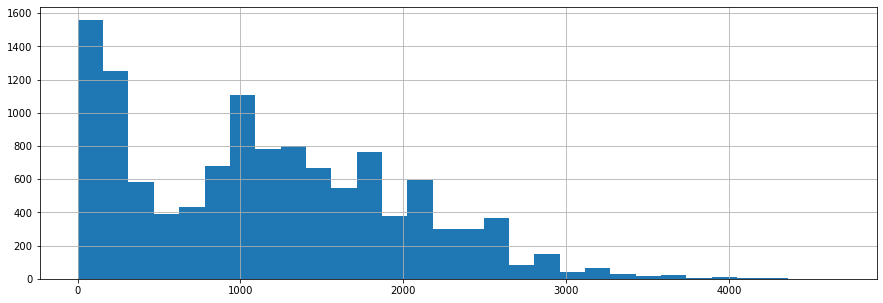

In [24]:
# Distributing the number of days since first review
listings_df["time_since_first_review"].hist(bins=30, figsize=(15,5))

In [25]:
# Defining the binning function
def bin_column(col, bins, labels):
    listings_df[col]=listings_df[col].astype(float)
    listings_df[col]=pd.cut(listings_df[col], bins=bins, labels=labels, include_lowest=True)
    listings_df[col]=listings_df[col].astype('str')
    listings_df[col]=listings_df[col].replace({"nan": "no review"})

In [26]:
# Binning time since first review
bin_column("time_since_first_review",
          bins=[0,180,365,730, 1460, max(listings_df.time_since_first_review)],
          labels=['0-6 months',
                 '6-12 months',
                 '1-2 years',
                 '2-3 years',
                 '4+ years'])

In [27]:
#Check the value counts
listings_df["time_since_first_review"].value_counts()

4+ years       4049
2-3 years      3758
no review      3223
0-6 months     1786
6-12 months    1265
1-2 years      1090
Name: time_since_first_review, dtype: int64

In [28]:
# Follow same process for last_review
listings_df["last_review"]=pd.to_datetime(listings_df["last_review"])

# Calculate the number of days since last review and date compilation
listings_df["time_since_last_review"]=(pd.datetime(2022,6,6) - listings_df["last_review"]).astype('timedelta64[D]')

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


<AxesSubplot:>

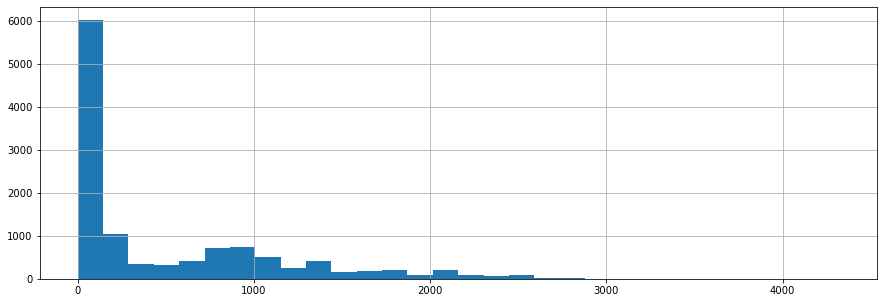

In [29]:
# Distributing the number of days since last review
listings_df["time_since_last_review"].hist(bins=30, figsize=(15,5))

In [30]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings_df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'])
           

In [31]:
# Check the value count
listings_df["time_since_last_review"].value_counts()

1+ year        4672
no review      3223
2-8 weeks      2610
0-2 weeks      2347
2-6 months     1473
6-12 months     846
Name: time_since_last_review, dtype: int64

In [32]:
#Drop the original columns
listings_df.drop(columns=["first_review", "last_review"], axis=1, inplace=True)

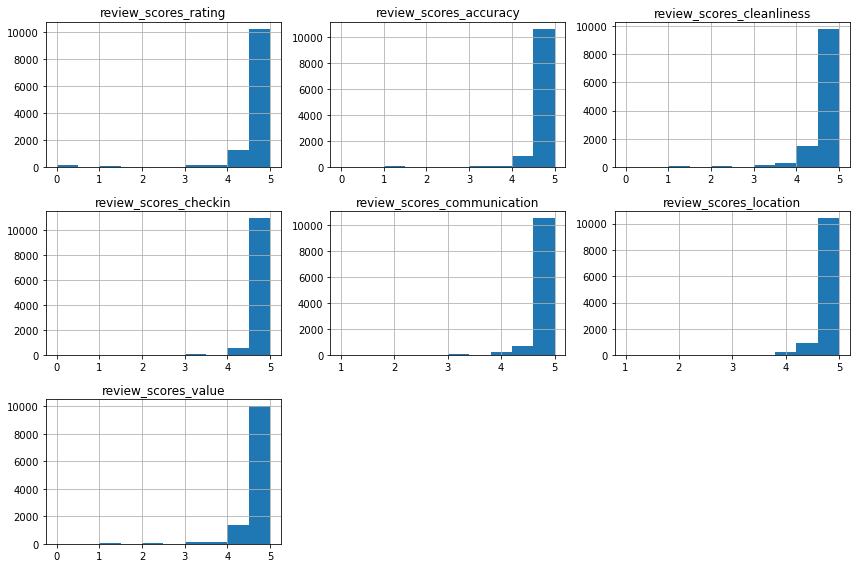

In [33]:
# review_rating_columns
# These columns have been binned into three categories based on their scores - poor, average and excellent

# Checking the distributions of the review ratings columns
review_variables = list(listings_df.columns[listings_df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(review_variables):
    ax = fig.add_subplot(3,3,i+1)
    listings_df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [34]:
# Replacing the null values in review columns with median values
for col in review_variables:
    listings_df[col].fillna(listings_df[col].median(),inplace=True)

In [35]:
# Create a new column for overage overall rating
col=listings_df.loc[:,"review_scores_rating":"review_scores_value"]
listings_df["avg_rating_overall"]=col.mean(axis=1)

In [36]:
# Binning the avg_rating_overall column
bins=[0,1.99,3.99,5]
labels=["poor", "average", "excellent"]

listings_df["avg_rating_overall_cat"]=pd.cut(listings_df["avg_rating_overall"], bins=bins, labels=labels, include_lowest=True)

In [37]:
# Replacing t/f with 1/0 in required columns
listings_df.replace({"f": 0, "t": 1}, inplace=True)

#### *Checking for Outliers*

In [38]:
# price
listings_df["price"].describe()

count    15171.000000
mean       178.591457
std        316.157766
min          0.000000
25%         75.000000
50%        120.000000
75%        200.000000
max      13000.000000
Name: price, dtype: float64

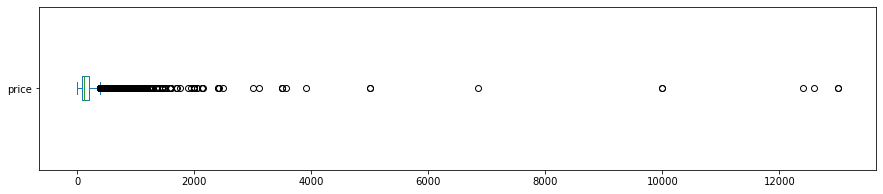

In [39]:
# Check the price column for outliers
listings_df.price.plot(kind="box", vert=False, figsize=(15,3))
plt.show()

In [40]:
#Check the entries for listing price greater than 800
listings_df.loc[listings_df["price"]>800]["price"].describe()

count      226.000000
mean      1685.106195
std       1855.060006
min        802.000000
25%        949.250000
50%       1128.000000
75%       1928.750000
max      13000.000000
Name: price, dtype: float64

In [41]:
# Count the cases where listing price is 0
listings_df.loc[listings_df.price==0]["price"].count()

1

In [42]:
# Drop the rows where price is greater than 800
listings_df.drop(listings_df[listings_df.price>800].index, axis=0, inplace=True)

#Drop the row where price is greater than 0
listings_df.drop(listings_df[listings_df.price==0].index, axis=0, inplace=True)

<AxesSubplot:>

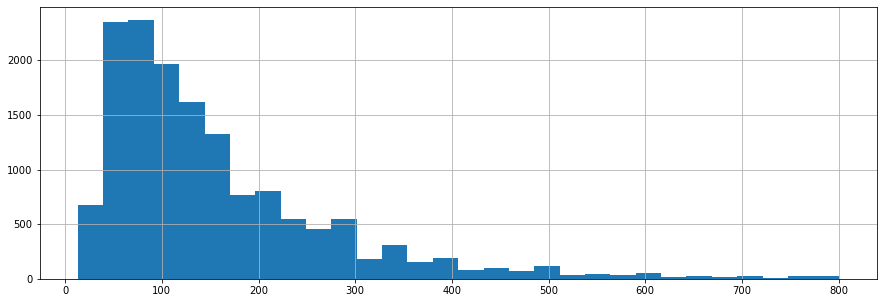

In [43]:
listings_df.price.hist(bins=30, figsize=(15,5))

In [44]:
# minimum_nights

listings_df["minimum_nights"].describe()

count    14944.000000
mean        25.514320
std         42.991313
min          1.000000
25%          3.000000
50%         28.000000
75%         28.000000
max       1125.000000
Name: minimum_nights, dtype: float64

In [45]:
#Check the entries for minimum nights higher than 90
listings_df.loc[listings_df["minimum_nights"]>90]["minimum_nights"].describe()

count     323.000000
mean      227.959752
std       184.452290
min        91.000000
25%       120.000000
50%       180.000000
75%       229.000000
max      1125.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:>

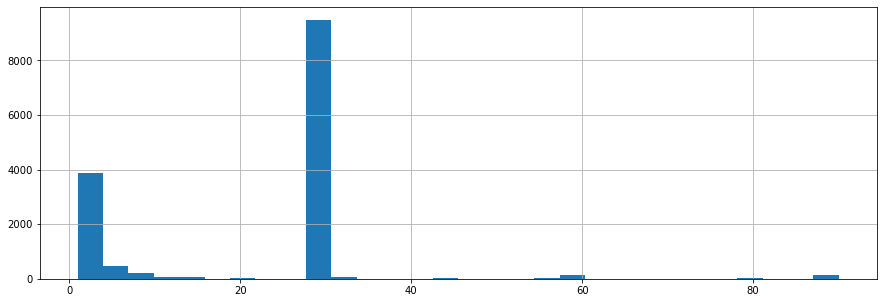

In [46]:
# Drop the rows where minimum_nights is greater than 90
listings_df.drop(listings_df[listings_df.minimum_nights>90].index, axis=0, inplace=True)
listings_df.minimum_nights.hist(bins=30, figsize=(15,5))

In [47]:
#Drop additinal null values
listings_df.dropna(how="any", inplace=True)

In [48]:
#Renaming the neighbourhood column
listings_df.rename(columns={"neighbourhood_cleansed":"neighbourhood"},inplace=True)
listings_df.head()

,id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,...,other_facilities,private_entrance,parking,kitchen,elevator,gym,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat
0,1419,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,-79.42423,House,...,0.0,0.0,0.0,1.0,0.0,0.0,4+ years,1+ year,5.000000,excellent
4,40456,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,-79.44010,House,...,1.0,1.0,1.0,1.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent
6,43964,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,-79.29188,House,...,1.0,1.0,1.0,1.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent
7,573892,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,-79.37985,Apartment,...,1.0,0.0,1.0,1.0,1.0,1.0,4+ years,2-8 weeks,4.845714,excellent
8,579918,unknown,unknown,0.0,1.0,1.0,Niagara,43.63987,-79.42034,Apartment,...,1.0,0.0,1.0,1.0,1.0,1.0,4+ years,1+ year,4.778571,excellent


In [49]:
# Prepare the datatypes for database
replacements={
    "object": "varchar",
    "float64": "float",
    "int64": "int",
    "datetime64[ns]": "timestamp",
    'timedelta64[ns]': "varchar"
}

replacements

{'object': 'varchar',
 'float64': 'float',
 'int64': 'int',
 'datetime64[ns]': 'timestamp',
 'timedelta64[ns]': 'varchar'}

In [50]:
# Replace the datatype for columns in dataframe
col_str=",".join("{} {}".format(n,d) for (n,d) in zip(listings_df.columns, listings_df.dtypes.replace(replacements)))
col_str

'id int,host_response_time varchar,host_response_rate varchar,host_is_superhost float,host_listings_count float,host_identity_verified float,neighbourhood varchar,latitude float,longitude float,property_type varchar,room_type varchar,accommodates int,bedrooms float,beds float,price float,minimum_nights int,maximum_nights int,availability_90 int,number_of_reviews int,review_scores_rating float,review_scores_accuracy float,review_scores_cleanliness float,review_scores_checkin float,review_scores_communication float,review_scores_location float,review_scores_value float,instant_bookable int,host_active_days float,toiletries float,high_end_electronics float,ac_heater float,internet float,bbq float,home_appliances float,coffee_machine float,long_term_stays float,host_greeting float,safety float,outdoor_space float,hot_tub_sauna_or_pool float,room_features float,other_facilities float,private_entrance float,parking float,kitchen float,elevator float,gym float,time_since_first_review varchar,

## Calendar

In [51]:
#Show the null values
calendar_df.isnull().sum()

listing_id        0
date              0
available         0
price             2
adjusted_price    2
minimum_nights    2
maximum_nights    2
dtype: int64

In [52]:
# Drop rows with nulls
calendar_df.dropna(how="any",inplace=True)

In [53]:
#Format the price column
calendar_df["price"]=calendar_df["price"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
calendar_df["price"]=calendar_df["price"].map("{:.0f}".format).astype(float)

In [54]:
#Format date column to extract weekday and month
calendar_df['date']=pd.to_datetime(calendar_df.date)
calendar_df['weekday'] =calendar_df['date'].dt.day_name()
calendar_df['month'] =calendar_df['date'].dt.month_name()

In [55]:
# Copy the clean data
clean_calendar_df=calendar_df.copy()

In [56]:
# Remove unwanted columns
clean_calendar_df.drop(columns=["adjusted_price","minimum_nights","maximum_nights"], inplace=True)

In [57]:
#Show dataframe
clean_calendar_df.head()

,listing_id,date,available,price,weekday,month
0,1419,2022-06-06,f,469.0,Monday,June
1,1419,2022-06-07,f,469.0,Tuesday,June
2,1419,2022-06-08,f,469.0,Wednesday,June
3,1419,2022-06-09,f,469.0,Thursday,June
4,1419,2022-06-10,f,469.0,Friday,June


In [58]:
#Format the listings id column for importing in PostgreSQL
clean_calendar_df["listing_id"]=clean_calendar_df["listing_id"].astype(str)

In [59]:
# Replace the datatype for columns in dataframe
col_str=",".join("{} {}".format(n,d) for (n,d) in zip(clean_calendar_df.columns, clean_calendar_df.dtypes.replace(replacements)))
col_str

'listing_id varchar,date timestamp,available varchar,price float,weekday varchar,month varchar'

## Insert Data into Database

In [60]:
# Get the config params
params_ = config()

# Connect to the Postgres_DB:
conn = psycopg2.connect(**params_)

# Create new_cursor allowing us to write Python to execute PSQL:
cur = conn.cursor()

conn.autocommit = True  # read documentation understanding when to Use & NOT use (TRUE)
print("opened database successfully")

opened database successfully


## Listings

In [61]:
#drop table listings with the same name
cur.execute("DROP TABLE IF EXISTS listings")

In [62]:
#create table
cur.execute("CREATE TABLE listings(\
 id varchar NOT NULL,\
 host_response_time varchar NOT NULL,\
 host_response_rate varchar NOT NULL,\
 host_is_superhost float NOT NULL,\
 host_listings_count float NOT NULL,\
 host_identity_verified float NOT NULL,\
 neighbourhood varchar NOT NULL,\
 latitude float NOT NULL,\
 longitude float NOT NULL,\
 property_type varchar NOT NULL,\
 room_type varchar NOT NULL,\
 accommodates int NOT NULL,\
 bedrooms float,beds float NOT NULL,\
 price float NOT NULL,\
 minimum_nights int NOT NULL,\
 maximum_nights int NOT NULL,\
 availability_90 int NOT NULL,\
 number_of_reviews int NOT NULL,\
 review_scores_rating float NOT NULL,\
 review_scores_accuracy float NOT NULL,\
 review_scores_cleanliness float NOT NULL,\
 review_scores_checkin float NOT NULL,\
 review_scores_communication float NOT NULL,\
 review_scores_location float NOT NULL,\
 review_scores_value float NOT NULL,\
 instant_bookable int NOT NULL,\
 host_active_days float NOT NULL,\
 toiletries float NOT NULL,\
 high_end_electronics float NOT NULL,\
 ac_heater float NOT NULL,\
 internet float NOT NULL,\
 bbq float NOT NULL,\
 home_appliances float NOT NULL,\
 coffee_machine float NOT NULL,\
 long_term_stays float NOT NULL,\
 host_greeting float NOT NULL,\
 safety float NOT NULL,\
 outdoor_space float NOT NULL,\
 hot_tub_sauna_or_pool float NOT NULL,\
 room_features float NOT NULL,\
 other_facilities float NOT NULL,\
 private_entrance float NOT NULL,\
 parking float NOT NULL,\
 kitchen float NOT NULL,\
 elevator float NOT NULL,\
 gym float NOT NULL,\
 time_since_first_review varchar NOT NULL,\
 time_since_last_review varchar  NOT NULL,\
 avg_rating_overall float  NOT NULL,\
 avg_rating_overall_cat varchar  NOT NULL,\
PRIMARY KEY(id))")

In [63]:
#Insert values into the table

#save df to csv
listings_df.to_csv('clean_listings.csv', header=listings_df.columns, index=False, encoding='utf-8')

#open the csv file, save it as an object, and upload to db
my_file=open('clean_listings.csv')
print("file opened in memory")

file opened in memory


In [64]:
# #Upload to database
SQL_STATEMENT= """
 COPY listings FROM STDIN WITH
     CSV
     HEADER
     DELIMITER AS ','
"""

cur.copy_expert(sql=SQL_STATEMENT, file=my_file)
print('file copied to db')

file copied to db


## Calendar

In [65]:
#drop table calendar with the same name
cur.execute("DROP TABLE IF EXISTS calendar")

In [66]:
#create table
cur.execute("CREATE TABLE calendar(\
 listing_id varchar NOT NULL,\
 date timestamp NOT NULL,\
 available varchar NOT NULL,\
 price float NOT NULL,\
 weekday varchar NOT NULL,\
 month varchar NOT NULL,\
PRIMARY KEY(listing_id,date))")

In [67]:
#Insert values into the table

#save df to csv
clean_calendar_df.to_csv('clean_calendar.csv', header=clean_calendar_df.columns, index=False, encoding='utf-8')

#open the csv file, save it as an object, and upload to db
my_file=open('clean_calendar.csv')
print("file opened in memory")

file opened in memory


In [68]:
# #Upload to database
SQL_STATEMENT= """
 COPY calendar FROM STDIN WITH
     CSV
     HEADER
     DELIMITER AS ','
"""

cur.copy_expert(sql=SQL_STATEMENT, file=my_file)
print('file copied to db')

file copied to db


## Scraping Data to find Toronto Borough Names

In [69]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text 

soup = BeautifulSoup(html_data, 'lxml')

# creating Toronto Dataframe
df_toronto = pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])


# scrapping all rows of the table
table_rows = soup.find('table').tbody.find_all('tr')

# filtering rows and inserting data to df_toronto
for rows in table_rows :
    for column in rows.find_all('td') :
        if column.span.text != 'Not assigned' :
            span  = column.span.text.split('(')
            df_toronto = df_toronto.append({'PostalCode' : column.b.text,
                              'Borough' : span[0],
                              'Neighborhood' : span[1][:-1]}, ignore_index=True)

In [70]:
df_toronto = df_toronto.sort_values('PostalCode').reset_index(drop = True)
df_toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West
9,M1N,Scarborough,Birch Cliff / Cliffside West


In [71]:
#Retrieving Postal Codes and Borough from sample rows

# convert an address into latitude and longitude values

# generating sample for testing  
rows = df_toronto.sample(frac =.10) 
  
# checking if sample is 0.25 times data or not 
if (0.10*(len(df_toronto))== len(rows)): 
    print( "Cool") 
    print(len(df_toronto), len(rows))

# Extract postal codes as list
postcodes_lst = rows['PostalCode'].tolist()

# Generate empty lists to store data
latitude = []
longitude = []

# Loop through each post code and retrieve lat and long
# used geocoder.argis instead of google
for i in postcodes_lst:
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

# add to dataframe as new colums
rows['Latitude'] = latitude
rows['Longitude'] = longitude

# display pandas df
rows

,PostalCode,Borough,Neighborhood,Latitude,Longitude
20,M2L,North York,York Mills / Silver Hills,43.758908,-79.370143
27,M3C,North York,Don Mills)Sout,43.724389,-79.343708
76,M6H,West Toronto,Dufferin / Dovercourt Village,43.664836,-79.437695
60,M5K,Downtown Toronto,Toronto Dominion Centre / Design Exchange,43.647707,-79.381722
44,M4N,Central Toronto,Lawrence Park,43.727298,-79.390157
19,M2K,North York,Bayview Village,43.773427,-79.377433
46,M4R,Central Toronto,North Toronto West,43.714785,-79.406276
3,M1G,Scarborough,Woburn,43.770647,-79.216741
65,M5R,Central Toronto,The Annex / North Midtown / Yorkville,43.671761,-79.403175
64,M5P,Central Toronto,Forest Hill North & West,43.700323,-79.404178


In [72]:
#Extract data for entire dataframe

# Extract postal codes as list
lst = df_toronto['PostalCode'].tolist()

# Generate empty lists to store data
latitude = []
longitude = []

# Loop through each post code and retrieve lat and long
# used geocoder.argis instead of google
for i in lst:
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

# add to dataframe as new colums
df_toronto['Latitude'] = latitude
df_toronto['Longitude'] = longitude
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.809154,-79.194867
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.787592,-79.156095
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.765523,-79.185671
3,M1G,Scarborough,Woburn,43.770647,-79.216741
4,M1H,Scarborough,Cedarbrae,43.768576,-79.238679


In [73]:
# read geojson neighborhoods
s3 = boto3.resource('s3', 
       aws_access_key_id=aws_access_key,
       aws_secret_access_key= aws_secret_access)

content_object = s3.Object('bc-final-airbnb-data', 'neighbourhoods.geojson')
file_content = content_object.get()['Body'].read().decode('utf-8')
map_df = gpd.read_file(file_content)

In [74]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [75]:
#Function to call the postal codes using geolocator

def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='group project')

In [76]:
map_df["PostalCode"]=map_df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field="latitude", lon_field="longitude")

In [77]:
map_df.drop(columns=["neighbourhood_group", "geometry"],inplace=True)

In [78]:
map_df["PostalCode"]=map_df["PostalCode"].str[:-4]
map_df.head()

,neighbourhood,longitude,latitude,PostalCode
0,York University Heights,-79.488883,43.765737,M3J
1,The Beaches,-79.299600,43.671050,M4L
2,Scarborough Village,-79.216813,43.738652,M1J
3,South Parkdale,-79.439338,43.636699,M6K
4,South Riverdale,-79.335651,43.649295,M4M


In [79]:
toronto_borough=df_toronto[["PostalCode","Borough"]]
toronto_borough

,PostalCode,Borough
0,M1B,Scarborough
1,M1C,Scarborough
2,M1E,Scarborough
3,M1G,Scarborough
4,M1H,Scarborough
...,...,...
98,M9N,York
99,M9P,Etobicoke
100,M9R,Etobicoke
101,M9V,Etobicoke


In [80]:
#Merging Borough Name with neighbourhoods
merged_df=map_df.merge(toronto_borough, left_on="PostalCode",right_on="PostalCode", how="left")
merged_df.head(10)

,neighbourhood,longitude,latitude,PostalCode,Borough
0,York University Heights,-79.488883,43.765737,M3J,North York
1,The Beaches,-79.299600,43.671050,M4L,East Toronto
2,Scarborough Village,-79.216813,43.738652,M1J,Scarborough
3,South Parkdale,-79.439338,43.636699,M6K,West Toronto
4,South Riverdale,-79.335651,43.649295,M4M,East Toronto
5,Centennial Scarborough,-79.150844,43.782377,M1C,Scarborough
6,Church-Yonge Corridor,-79.379018,43.659649,M5B,Downtown Toronto
7,Guildwood,-79.195054,43.748829,M1E,Scarborough
8,Waterfront Communities-The Island,-79.377201,43.633881,M5J,Downtown Toronto
9,West Hill,-79.176676,43.767490,M1E,Scarborough


In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  140 non-null    object 
 1   longitude      140 non-null    float64
 2   latitude       140 non-null    float64
 3   PostalCode     140 non-null    object 
 4   Borough        133 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.6+ KB


In [82]:
# Fill the null values with 'unkown'
merged_df['Borough'].fillna('unkown', inplace=True)

In [83]:
merged_df.head()

,neighbourhood,longitude,latitude,PostalCode,Borough
0,York University Heights,-79.488883,43.765737,M3J,North York
1,The Beaches,-79.299600,43.671050,M4L,East Toronto
2,Scarborough Village,-79.216813,43.738652,M1J,Scarborough
3,South Parkdale,-79.439338,43.636699,M6K,West Toronto
4,South Riverdale,-79.335651,43.649295,M4M,East Toronto


In [84]:
# Replace the datatype for columns in dataframe
col_str=",".join("{} {}".format(n,d) for (n,d) in zip(merged_df.columns, merged_df.dtypes.replace(replacements)))
col_str

'neighbourhood varchar,longitude float,latitude float,PostalCode varchar,Borough varchar'

In [85]:
#drop table neighbourhood with the same name
cur.execute("DROP TABLE IF EXISTS neighbourhood")

In [86]:
cur.execute("CREATE TABLE neighbourhood(\
    neighbourhood varchar NOT NULL,\
    longitude float NOT NULL,\
    latitude float NOT NULL,\
    PostalCode varchar,\
    Borough varchar,\
PRIMARY KEY(neighbourhood))")

In [87]:
#Insert values into the table

# save df to csv
merged_df.to_csv('neighbourhood.csv', header=merged_df.columns, index=False, encoding='utf-8')

# open the csv file, save it as an object, and upload to db
my_file=open('neighbourhood.csv')
print("file opened in memory")

file opened in memory


In [88]:
# #Upload to database
SQL_STATEMENT= """
 COPY neighbourhood FROM STDIN WITH
     CSV
     HEADER
     DELIMITER AS ','
"""

cur.copy_expert(sql=SQL_STATEMENT, file=my_file)
print('file copied to db')

file copied to db


## Final Merge with Listings dataset

In [89]:
#Merge the listings data
clean_df=listings_df.merge(merged_df,on=["neighbourhood"], how="left")
clean_df.head()
clean_df.drop(columns=["longitude_y","latitude_y","PostalCode"],inplace=True)

In [90]:
clean_df["Borough"].fillna("unknown",inplace=True)
clean_df.rename(columns={"Borough": "borough", "latitude_x":"latitude", "longitude_x":"longitude"}, inplace=True)

In [91]:
print(clean_df.shape)
clean_df.head()

(10801, 52)


,id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,...,private_entrance,parking,kitchen,elevator,gym,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat,borough
0,1419,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,-79.42423,House,...,0.0,0.0,1.0,0.0,0.0,4+ years,1+ year,5.000000,excellent,West Toronto
1,40456,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,-79.44010,House,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent,West Toronto
2,43964,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,-79.29188,House,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent,Scarborough
3,573892,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,-79.37985,Apartment,...,0.0,1.0,1.0,1.0,1.0,4+ years,2-8 weeks,4.845714,excellent,Downtown Toronto
4,579918,unknown,unknown,0.0,1.0,1.0,Niagara,43.63987,-79.42034,Apartment,...,0.0,1.0,1.0,1.0,1.0,4+ years,1+ year,4.778571,excellent,West Toronto


In [92]:
# Replace the datatype for columns in dataframe
col_str=",".join("{} {}".format(n,d) for (n,d) in zip(clean_df.columns, clean_df.dtypes.replace(replacements)))
col_str

'id int,host_response_time varchar,host_response_rate varchar,host_is_superhost float,host_listings_count float,host_identity_verified float,neighbourhood varchar,latitude float,longitude float,property_type varchar,room_type varchar,accommodates int,bedrooms float,beds float,price float,minimum_nights int,maximum_nights int,availability_90 int,number_of_reviews int,review_scores_rating float,review_scores_accuracy float,review_scores_cleanliness float,review_scores_checkin float,review_scores_communication float,review_scores_location float,review_scores_value float,instant_bookable int,host_active_days float,toiletries float,high_end_electronics float,ac_heater float,internet float,bbq float,home_appliances float,coffee_machine float,long_term_stays float,host_greeting float,safety float,outdoor_space float,hot_tub_sauna_or_pool float,room_features float,other_facilities float,private_entrance float,parking float,kitchen float,elevator float,gym float,time_since_first_review varchar,

In [93]:
#drop table neighbourhood with the same name
cur.execute("DROP TABLE IF EXISTS summary")

In [94]:
cur.execute("CREATE TABLE summary(\
    id varchar NOT NULL, \
    host_response_time varchar NOT NULL, \
    host_response_rate varchar NOT NULL, \
    host_is_superhost float NOT NULL, \
    host_listings_count float NOT NULL, \
    host_identity_verified float NOT NULL, \
    neighbourhood varchar NOT NULL, \
    latitude float  NOT NULL, \
    longitude float NOT NULL, \
    property_type varchar NOT NULL, \
    room_type varchar NOT NULL, \
    accommodates int  NOT NULL, \
    bedrooms float NOT NULL, \
    beds float NOT NULL, \
    price float NOT NULL, \
    minimum_nights int NOT NULL, \
    maximum_nights int NOT NULL, \
    availability_90 int NOT NULL, \
    number_of_reviews int  NOT NULL, \
    review_scores_rating float NOT NULL, \
    review_scores_accuracy float NOT NULL, \
    review_scores_cleanliness float NOT NULL, \
    review_scores_checkin float NOT NULL, \
    review_scores_communication float NOT NULL, \
    review_scores_location float NOT NULL, \
    review_scores_value float NOT NULL, \
    instant_bookable int NOT NULL, \
    host_active_days float NOT NULL, \
    toiletries float NOT NULL, \
    high_end_electronics float NOT NULL, \
    ac_heater float,internet float NOT NULL, \
    bbq float,home_appliances float NOT NULL, \
    coffee_machine float NOT NULL, \
    long_term_stays float NOT NULL, \
    host_greeting float NOT NULL, \
    safety float,outdoor_space float NOT NULL, \
    hot_tub_sauna_or_pool float NOT NULL, \
    room_features float NOT NULL, \
    other_facilities float NOT NULL, \
    private_entrance float NOT NULL, \
    parking float NOT NULL, \
    kitchen float,elevator float NOT NULL, \
    gym float NOT NULL, \
    time_since_first_review varchar NOT NULL, \
    time_since_last_review varchar NOT NULL, \
    avg_rating_overall float NOT NULL, \
    avg_rating_overall_cat varchar  NOT NULL, \
    borough varchar NOT NULL, \
PRIMARY KEY(id))")

In [98]:
#Insert values into the table

# save df to csv
clean_df.to_csv('summary.csv', header=clean_df.columns, index=False, encoding='utf-8')

# open the csv file, save it as an object, and upload to db
my_file=open('summary.csv')
print("file opened in memory")

file opened in memory


In [99]:
# #Upload to database
SQL_STATEMENT= """
 COPY summary FROM STDIN WITH
     CSV
     HEADER
     DELIMITER AS ','
"""

cur.copy_expert(sql=SQL_STATEMENT, file=my_file)
print('file copied to db')

file copied to db
